# About this Dataset
Context
These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

Content
This dataset consists of the following files:

movies_metadata.csv: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

In [20]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Read the movies metadata csv file

In [22]:
df = pd.read_csv("movies_metadata.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Only keep the numeric columns for our analysis. However, we'll keep titles also to interpret the results at the end of clustering. Note that this title column will not be used in the analysis.

In [23]:
df.drop(df.index[19730],inplace=True)
df.drop(df.index[29502],inplace=True)
df.drop(df.index[35585],inplace=True)

In [24]:
df_numeric = df[['budget','popularity','revenue','runtime','vote_average','vote_count','title']]

In [25]:
df_numeric.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title
0,30000000,21.9469,373554033.0,81.0,7.7,5415.0,Toy Story
1,65000000,17.0155,262797249.0,104.0,6.9,2413.0,Jumanji
2,0,11.7129,0.0,101.0,6.5,92.0,Grumpier Old Men
3,16000000,3.85949,81452156.0,127.0,6.1,34.0,Waiting to Exhale
4,0,8.38752,76578911.0,106.0,5.7,173.0,Father of the Bride Part II


Check if rows contain any null values

In [26]:
df_numeric.isnull().sum()

budget            0
popularity        3
revenue           3
runtime         260
vote_average      3
vote_count        3
title             3
dtype: int64

Drop all the rows with null values

In [27]:
df_numeric.dropna(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Let's see the statistics for the votes counts for the movies data

In [28]:
df_numeric['vote_count'].describe()

count    45203.000000
mean       110.506515
std        492.638190
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

We see that a half of movies have been rated less than 10 times. For easier interpretability, let's take only the movies that have more than 30 votes, i.e. top 26% of the movies.

In [29]:
df_numeric['vote_count'].quantile(np.arange(.74,1,0.01))

0.74      32.00
0.75      34.00
0.76      37.00
0.77      40.00
0.78      43.00
0.79      46.00
0.80      51.00
0.81      55.00
0.82      61.00
0.83      67.00
0.84      74.00
0.85      83.00
0.86      92.00
0.87     104.74
0.88     119.00
0.89     139.00
0.90     161.00
0.91     193.00
0.92     230.00
0.93     283.00
0.94     349.00
0.95     435.90
0.96     581.00
0.97     827.94
0.98    1243.88
0.99    2196.84
Name: vote_count, dtype: float64

In [30]:
df_numeric = df_numeric[df_numeric['vote_count']>30]

In [31]:
df_numeric.shape

(12178, 7)

## Normalize data
Normalize the data with MinMax scaling provided by sklearn

In [32]:
from sklearn import preprocessing

In [33]:
minmax_processed = preprocessing.MinMaxScaler().fit_transform(df_numeric.drop('title',axis=1))

In [34]:
df_numeric_scaled = pd.DataFrame(minmax_processed, index=df_numeric.index, columns=df_numeric.columns[:-1])

In [35]:
df_numeric_scaled.head()

,budget,popularity,revenue,runtime,vote_average,vote_count
0,0.078947,0.040082,0.133988,0.092360,0.810526,0.383367
1,0.171053,0.031075,0.094261,0.118586,0.726316,0.169610
2,0.000000,0.021389,0.000000,0.115165,0.684211,0.004343
3,0.042105,0.007045,0.029216,0.144812,0.642105,0.000214
4,0.000000,0.015315,0.027468,0.120867,0.600000,0.010111


## Apply K-Means Clustering

### What k to choose?
Let's fit cluster size 1 to 15 on our data and take a look at the corresponding score value.

In [36]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]

In [37]:
score = [kmeans[i].fit(df_numeric_scaled).score(df_numeric_scaled) for i in range(len(kmeans))]

These score values signify how far our observations are from the cluster center. We want to keep this score value around 0. A large positive or a large negative value would indicate that the cluster center is far from the observations.

Based on these scores value, we plot an Elbow curve to decide which cluster size is optimal. Note that we are dealing with tradeoff between cluster size(hence the computation required) and the relative accuracy.

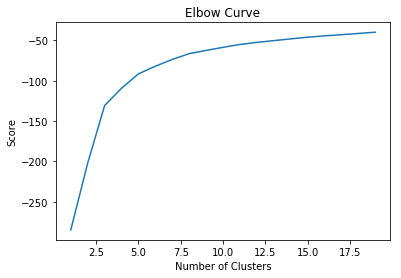

In [38]:
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Our Elbow point is around cluster size of ?. We will use k=? to further interpret our clustering result.

### Fit K-Means clustering for k=?

In [39]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_numeric_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

As a result of clustering, we have the clustering label. Let's put these labels back into the original numeric data frame.

In [40]:
len(kmeans.labels_)

12178

In [41]:
df_numeric['cluster'] = kmeans.labels_

In [42]:
df_numeric.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
0,30000000,21.9469,373554033.0,81.0,7.7,5415.0,Toy Story,2
1,65000000,17.0155,262797249.0,104.0,6.9,2413.0,Jumanji,1
2,0,11.7129,0.0,101.0,6.5,92.0,Grumpier Old Men,0
3,16000000,3.85949,81452156.0,127.0,6.1,34.0,Waiting to Exhale,0
4,0,8.38752,76578911.0,106.0,5.7,173.0,Father of the Bride Part II,0


## Interpret clustering results

Let's see cluster sizes first.

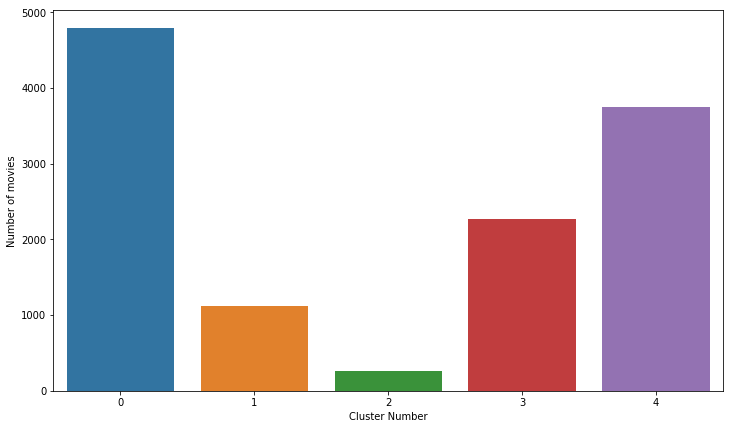

In [43]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,5,1),y=df_numeric.groupby(['cluster']).count()['budget'].values)
x=axis.set_xlabel("Cluster Number")
x=axis.set_ylabel("Number of movies")

We clearly see that one cluster is the largest and one cluster has the fewest number of movies.

Let's look at the cluster statistics.

In [44]:
df_numeric.groupby(['cluster']).mean()

,revenue,runtime,vote_average,vote_count
cluster,,,,
0,1.444391e+07,100.416632,6.189114,169.735061
1,1.622144e+08,114.305009,6.214222,1135.059034
2,6.301488e+08,126.231660,6.904247,4740.281853
3,1.038309e+07,93.710387,4.941901,123.371479
4,1.687969e+07,109.901950,7.278520,304.510286


* We see that one cluster which is also the smallest, is the cluster of movies that received maximum number of votes(in terms of counts) and also have very high popularity and total runtime and net revenue. Let's see some of the movies that belong to this cluster.

In [45]:
size_array = list(df_numeric.groupby(['cluster']).count()['budget'].values)

In [46]:
size_array

[4786, 1118, 259, 2272, 3743]

In [47]:
df_numeric[df_numeric['cluster']==size_array.index(sorted(size_array)[0])].sample(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
19814,120000000,26.081,829000000.0,115.0,6.1,2641.0,The Twilight Saga: Breaking Dawn - Part 2,2
13694,150000000,15.4172,413106170.0,105.0,5.9,2026.0,Night at the Museum: Battle of the Smithsonian,2
22058,130000000,25.3091,847423452.0,146.0,7.4,6656.0,The Hunger Games: Catching Fire,2
7909,200000000,10.8345,783766341.0,127.0,6.7,4432.0,Spider-Man 2,2
10973,210000000,0.867943,459359555.0,104.0,6.3,3581.0,X-Men: The Last Stand,2


We see many big movie names in this cluster. So the results are intuitive.

* Cluster that is the second smallest cluster in the results, has 2nd highest votes count and the most highly rated movies. The runtime for these movies is on the higher end and popularity score is also good. Let's see some of the movie names from this cluster.

In [48]:
df_numeric[df_numeric['cluster']==size_array.index(sorted(size_array)[1])].sample(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
3362,95000000,8.75519,76432727.0,89.0,7.0,892.0,The Road to El Dorado,1
8081,40000000,8.24889,95149435.0,113.0,6.0,726.0,The Princess Diaries 2: Royal Engagement,1
15344,110000000,16.7478,177238796.0,117.0,6.2,1737.0,The A-Team,1
6018,50000000,7.46978,88323487.0,115.0,6.0,707.0,Shanghai Knights,1
777,80000000,11.9958,159212469.0,115.0,5.8,385.0,Daylight,1


* Lastly, let's take a look at the least successful movies. This cluster represents the movies that recieved least number of votes and also has the smallest runtime, revenue and popularity score.

In [49]:
df_numeric[df_numeric['cluster']==size_array.index(sorted(size_array)[-1])].sample(5)

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
10669,0,7.16555,0.0,90.0,5.8,140.0,Yamakasi,0
2982,0,3.79619,0.0,109.0,6.3,41.0,Shampoo,0
110,7500000,12.3143,32392047.0,91.0,6.5,245.0,Rumble in the Bronx,0
11252,20000000,9.99654,0.0,115.0,5.9,125.0,The Last Kiss,0
1280,0,14.0032,86432000.0,117.0,6.2,192.0,The Amityville Horror,0


As we can see this cluster also includes the movies for which our dataset has no information about the budget and revenue, hence there corresponding fields have 0 value in it. This pulls down the net revenue of the whole cluster. If we keep the cluster size slightly larger, we might get to see these movies clustered separately.